# <a name="B1">Algorithme de détéction des faux billets avec Python</a>

# Sommaire

* **[Mise en place du jeu de données](#chapter1)**
    * [Importation des librairies et des fichiers nécessaires au projet](#section_1_1)
    * [Présentation et vérification des fichiers](#section_1_2)
    * [Nettoyage des données](#section_1_3)
    * [Analyses exploratoires des données](#section_1_4)
*  **[Modélisations des données](#chapter2)**
    * [Régression logistique](#section_2_1)
    * [ K-Means](#section_2_2)
    * [Algorithme de prédiction](#section_2_3)



# Mise en place du jeu de données <a class="anchor" id="chapter1">


## <font color='purple'>Importation des librairies et des fichiers nécessaires au projet <a class="anchor" id="section_1_1"></a>


In [1]:
# Chargement des librairies

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_theme(style="whitegrid")
from matplotlib import pyplot

import scipy.stats as stats
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.stats import t, shapiro
from scipy.stats import pearsonr

from sklearn import decomposition
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer


from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import confusion_matrix,classification_report
from sklearn import metrics
from sklearn.metrics import accuracy_score

import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor




## <font color='purple'>Présentation et vérification des fichiers <a class="anchor" id="section_1_2"></a>


In [2]:
#chargement du jeu de données billets
billet = pd.read_csv('billets.csv', sep=";") 

In [3]:
billet.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54


In [4]:
billet.tail()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
1495,False,171.75,104.38,104.17,4.42,3.09,111.28
1496,False,172.19,104.63,104.44,5.27,3.37,110.97
1497,False,171.80,104.01,104.12,5.51,3.36,111.95
1498,False,172.06,104.28,104.06,5.17,3.46,112.25
1499,False,171.47,104.15,103.82,4.63,3.37,112.07


In [5]:
billet.sample(5)

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
981,True,172.02,104.23,103.72,NaN,2.99,113.37
943,True,171.79,103.56,103.77,4.15,2.80,112.67
852,True,171.92,103.72,103.66,4.41,2.65,113.40
490,True,172.13,103.71,103.60,3.59,3.12,113.80
960,True,171.87,103.88,104.07,3.80,2.90,113.36


### Structure du jeu de données

In [6]:
billet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1463 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 71.9 KB


In [7]:
billet.dtypes.value_counts()

float64    6
bool       1
dtype: int64

In [8]:
billet.describe()

,diagonal,height_left,height_right,margin_low,margin_up,length
count,1500.000000,1500.000000,1500.000000,1463.000000,1500.000000,1500.00000
mean,171.958440,104.029533,103.920307,4.485967,3.151473,112.67850
std,0.305195,0.299462,0.325627,0.663813,0.231813,0.87273
min,171.040000,103.140000,102.820000,2.980000,2.270000,109.49000
25%,171.750000,103.820000,103.710000,4.015000,2.990000,112.03000
50%,171.960000,104.040000,103.920000,4.310000,3.140000,112.96000
75%,172.170000,104.230000,104.150000,4.870000,3.310000,113.34000
max,173.010000,104.880000,104.950000,6.900000,3.910000,114.44000


## <font color='purple'>Nettoyage des données <a class="anchor" id="section_1_3"></a>


In [9]:
billet.isna().sum()

is_genuine       0
diagonal         0
height_left      0
height_right     0
margin_low      37
margin_up        0
length           0
dtype: int64

La varible **margin_low** a 37 valeurs manquantes, affichons ces lignes.

In [10]:
val_manquantes=billet[billet.isnull().any(axis=1)]
val_manquantes.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
72,True,171.94,103.89,103.45,NaN,3.25,112.79
99,True,171.93,104.07,104.18,NaN,3.14,113.08
151,True,172.07,103.80,104.38,NaN,3.02,112.93
197,True,171.45,103.66,103.80,NaN,3.62,113.27
241,True,171.83,104.14,104.06,NaN,3.02,112.36


In [11]:
val_manquantes.shape

(37, 7)

Il y a 37 valeurs manquantes.

In [12]:
billet_sans_vm=billet.dropna(inplace=False)
billet_sans_vm.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54


### Gestion des valeurs manquantes: imputations par régression linéaire

### Régression linéaire

In [13]:
reg_multi = smf.ols('margin_low~diagonal+height_left+height_right+margin_up+length', data=billet_sans_vm).fit()
print(reg_multi.summary())


                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.477
Model:                            OLS   Adj. R-squared:                  0.476
Method:                 Least Squares   F-statistic:                     266.1
Date:                Thu, 08 Sep 2022   Prob (F-statistic):          2.60e-202
Time:                        09:24:45   Log-Likelihood:                -1001.3
No. Observations:                1463   AIC:                             2015.
Df Residuals:                    1457   BIC:                             2046.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       22.9948      9.656      2.382   

On remarque qu'à présent, tous les paramètres sont significatifs. Quant au $R^{2}$, il vaut environ 0.48, tout comme le $R^{2}$ ajusté.


In [14]:
# vérification de la colinéarité des variables explicatives
variables = reg_multi.model.exog
[variance_inflation_factor(variables, i) for i in np.arange(1,variables.shape[1])]

[1.0136128990686295,
 1.1382605736082487,
 1.2301145155560365,
 1.4044037781843624,
 1.5769501453665813]

Les variables explicatives ne sont pas corrélés entre eux, tous les VIF(facteur d'influence de la variance) sont proche de 1.

In [15]:
#Test d'homoscédasticité
#Appliquons un test de Breusch Pagan pour tester l'homoscedasticité des résidus
# H0: Homoscédasticité des résidus.
_, pval, __, f_pval = statsmodels.stats.diagnostic.het_breuschpagan( reg_multi.resid, variables)
print('p value test Breusch Pagan:', pval)


p value test Breusch Pagan: 7.759535216069813e-16


La p-value est très inférieure à 0.05, on ne rejette donc pas H0, et on peut considérer qu'il y a bien homoscédasticité des résidus.

In [16]:
# Test de normalité des résidus
reg_multi.resid.head()

0   -0.268676
1   -0.368908
2    0.274067
3   -0.536580
4   -0.537425
dtype: float64

In [17]:
reg_multi.resid.mean()

-2.538818248060388e-13

La moyenne des résidus est très proche de **0**.</br>
Analysons maintenant sa distribution.

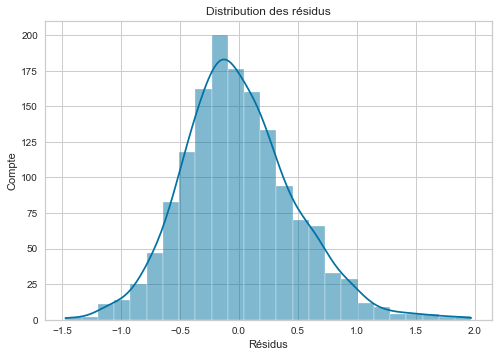

In [18]:
sns.histplot(reg_multi.resid, kde=True,bins=25)
plt.xlabel("Résidus")
plt.ylabel("Compte")
plt.title("Distribution des résidus")
plt.show()


Réalisons maintenant un test de shapiro pour déterminer si les résidus sont normalement distribués. </br>**L'hypothèse nulle** est que la population est normalement distribuée.

In [19]:
shapiro(reg_multi.resid)

ShapiroResult(statistic=0.9857879281044006, pvalue=8.536943374437556e-11)

La pvalue est très inférieure à 0,05 et **nous rejetons donc l'hypothèse H0**, donc la normalité de la distribution des résidus n'est pas vérifiée.</br>
Cependant, le fait que la distribution est presque symétrique, et que l'échantillon soit de taille suffisante (supérieure à 30) alors on peut dire que les résultats obtenus par le modèle linéaire gaussien ne sont pas absurdes, même si le résidu n'est pas considéré comme étant gaussien.

Nous pourrons donc utiliser ce modèle pour remplacer les valeurs manquantes.

In [20]:
#prédiction
margin_low_pred = round(reg_multi.predict(billet),2)

In [21]:
billet.loc[billet['margin_low'].isna(), 'margin_low']=margin_low_pred

In [22]:
billet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1500 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 71.9 KB


Il n'y a plus de valeurs manquantes.

In [23]:
billet.describe()

,diagonal,height_left,height_right,margin_low,margin_up,length
count,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.00000
mean,171.958440,104.029533,103.920307,4.483480,3.151473,112.67850
std,0.305195,0.299462,0.325627,0.659643,0.231813,0.87273
min,171.040000,103.140000,102.820000,2.980000,2.270000,109.49000
25%,171.750000,103.820000,103.710000,4.020000,2.990000,112.03000
50%,171.960000,104.040000,103.920000,4.310000,3.140000,112.96000
75%,172.170000,104.230000,104.150000,4.870000,3.310000,113.34000
max,173.010000,104.880000,104.950000,6.900000,3.910000,114.44000


## <font color='purple'>Analyses exploratoires des données <a class="anchor" id="section_1_4"></a>


### Analyse descriptive des billets

In [24]:
print(billet.groupby(["is_genuine"]).count())


            diagonal  height_left  height_right  margin_low  margin_up  length
is_genuine                                                                    
False            500          500           500         500        500     500
True            1000         1000          1000        1000       1000    1000


Il a **1000** vrais billets et **500** faux billets.

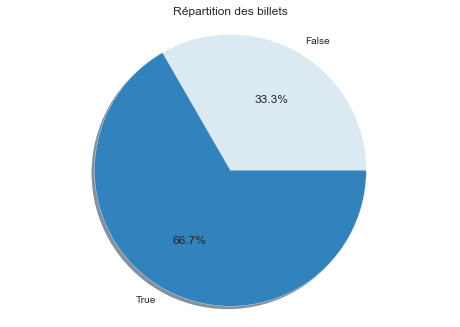

In [25]:
# représentation graphique de la répartition des vrais et faux billets

fig1, ax1 = plt.subplots()
ax1.pie(billet.groupby(["is_genuine"])["diagonal"].count(),
        labels=["False","True"],
        autopct="%1.1f%%",
        colors=["#dbe9f3","#3182bd"],
        shadow=True)
ax1.axis("equal")
plt.title("Répartition des billets")
plt.show()


In [26]:
billet_df=billet.set_index('is_genuine')
billet_df.head()

,diagonal,height_left,height_right,margin_low,margin_up,length
is_genuine,,,,,,
True,171.81,104.86,104.95,4.52,2.89,112.83
True,171.46,103.36,103.66,3.77,2.99,113.09
True,172.69,104.48,103.50,4.40,2.94,113.16
True,171.36,103.91,103.94,3.62,3.01,113.51
True,171.73,104.28,103.46,4.04,3.48,112.54


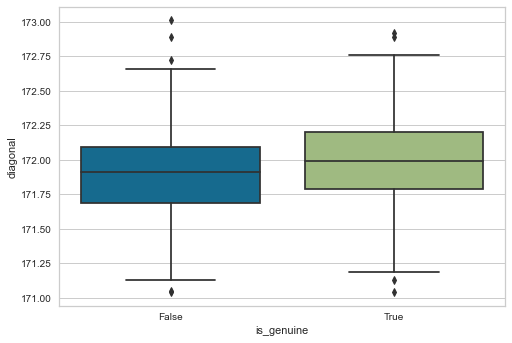

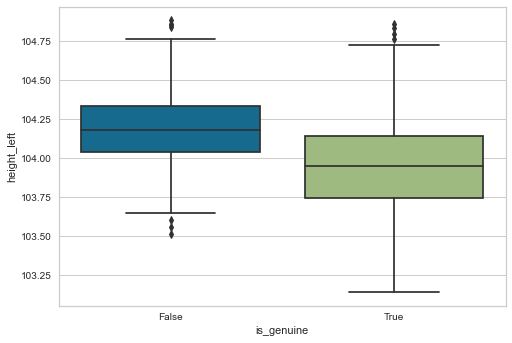

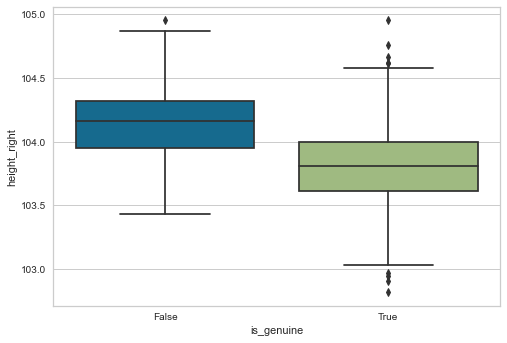

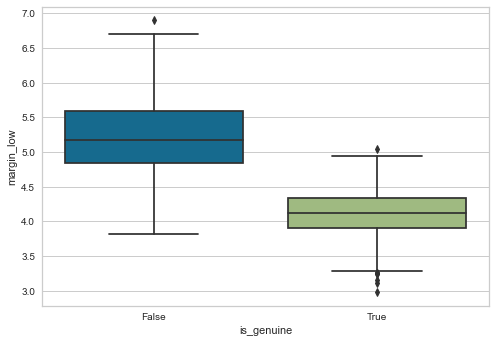

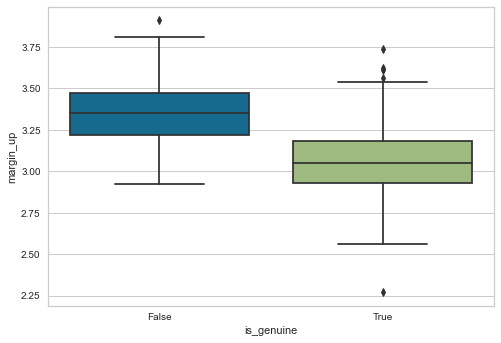

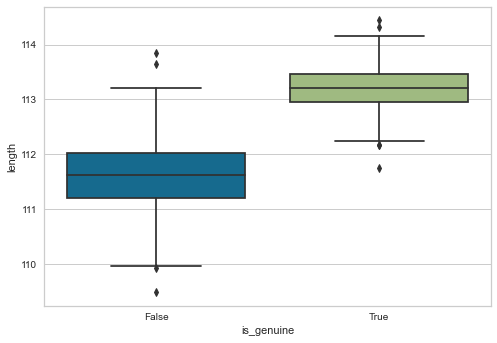

In [27]:
#boxplot en fonction de "is_genuine"
for i in billet_df.columns:
    sns.boxplot(x="is_genuine", y=i, data= billet)
    plt.show()
    


On constate que les variances entre les vrais et faux billets pour les variables **length** et **margin_low** sont différentes alors que celles des autres variables sont assez semblables. </br> Les médianes entre les vrais et faux billets pour tous les variables sont différentes.</br>


### Analyse bivariée 

In [28]:
billet.corr()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
is_genuine,1.000000,0.132756,-0.379833,-0.485092,-0.783452,-0.606262,0.849285
diagonal,0.132756,1.000000,0.019472,-0.024492,-0.110666,-0.055649,0.097587
height_left,-0.379833,0.019472,1.000000,0.242279,0.309214,0.246522,-0.320863
height_right,-0.485092,-0.024492,0.242279,1.000000,0.393522,0.307005,-0.401751
margin_low,-0.783452,-0.110666,0.309214,0.393522,1.000000,0.434250,-0.670987
margin_up,-0.606262,-0.055649,0.246522,0.307005,0.434250,1.000000,-0.520575
length,0.849285,0.097587,-0.320863,-0.401751,-0.670987,-0.520575,1.000000


La variable à expiquer **is_genuine** est corrélé avec : **margin_low** et **length**.

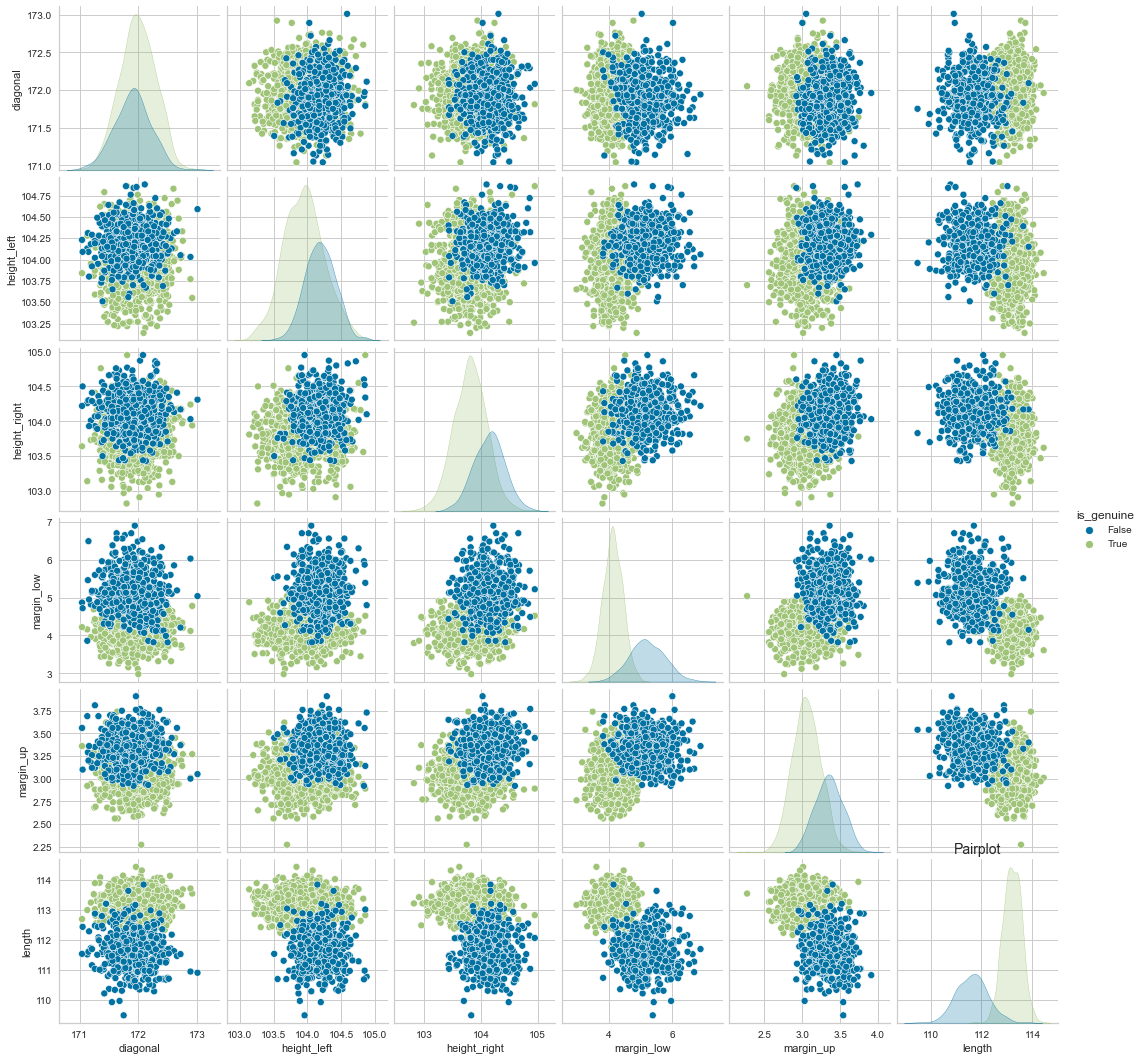

In [29]:
sns.pairplot(billet, hue="is_genuine")
plt.title('Pairplot').set_fontsize(14)
plt.savefig('Pairplot',dpi=300)



***Analyse  du graphique du pairplot***</br> </br>
D'après les figures sur la diagonale, on constate que la variable **margin_low** pour les**vrais billets** sont **supérieures** que pour les **faux billets**.Même constat aussi pour la variable **length**.</br> On peut identifier alors un billet à partir de ces deux variables. </br>


### Analyse en composantes principales


In [30]:
billet= billet.set_index("is_genuine")


In [31]:
# Preparation des données pour l'ACP
X= billet
names = billet.index
nom_variable = billet.columns

In [32]:
#Standardisation(centrage et réduction)
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

In [33]:
X.head()

,diagonal,height_left,height_right,margin_low,margin_up,length
is_genuine,,,,,,
True,171.81,104.86,104.95,4.52,2.89,112.83
True,171.46,103.36,103.66,3.77,2.99,113.09
True,172.69,104.48,103.50,4.40,2.94,113.16
True,171.36,103.91,103.94,3.62,3.01,113.51
True,171.73,104.28,103.46,4.04,3.48,112.54


In [34]:
# calcul des composantes principales
pca = decomposition.PCA(n_components=6) # correspond aux 6 variables
pca.fit(X_scaled)


PCA(n_components=6)

In [35]:
# Je crée une df qui affiche la variance expliquée pour chaque dimension.
variance = pd.DataFrame(
    {
        "Dimension" : ["Dim" + str(x + 1) for x in range(6)], 
        "Variance expliquée" : pca.explained_variance_,
        "% variance expliquée" : np.round(pca.explained_variance_ratio_ * 100),
        "% cum. var. expliquée" : np.round(np.cumsum(pca.explained_variance_ratio_) * 100)
    }
)
variance


,Dimension,Variance expliquée,% variance expliquée,% cum. var. expliquée
0,Dim1,2.599036,43.0,43.0
1,Dim2,1.018072,17.0,60.0
2,Dim3,0.782027,13.0,73.0
3,Dim4,0.709971,12.0,85.0
4,Dim5,0.576552,10.0,95.0
5,Dim6,0.318345,5.0,100.0


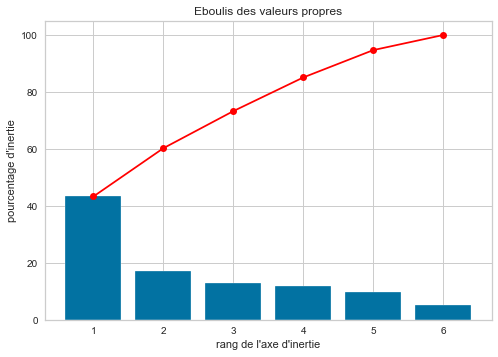

In [36]:
 #Eboulis des valeurs propres
    
def display_scree_plot(pca):
    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel("rang de l'axe d'inertie")
    plt.ylabel("pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres")
    plt.show(block=False)
display_scree_plot(pca)

In [37]:
# Calcul des composantes principales
n_comp = 3  # les 3 composantes principales représentent 73% des données
pca = decomposition.PCA(n_components=n_comp)
pca.fit(X_scaled)


PCA(n_components=3)

In [38]:
res_pca = pca.fit_transform(X_scaled)


### Cercle de corrélation

In [39]:
# Fonction qui me permet d'afficher mes cercles de corrélations

def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    for d1, d2 in axis_ranks: # On affiche les 3 premiers plans factoriels, donc les 6 premières composantes
        if d2 < n_comp:

            # initialisation de la figure
            fig, ax = plt.subplots(figsize=(8,8))

            # détermination des limites du graphique
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # affichage des flèches
            # s'il y a plus de 30 flèches, on n'affiche pas le triangle à leur extrémité
            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:],
                   angles='xy', scale_units='xy', scale=1, color="orange")
                
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
           
            # affichage des noms des variables  
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(x, y, labels[i], fontsize='14', ha='center', va='center', rotation=label_rotation, color="blue", alpha=0.5)
           
            # affichage du cercle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)

            # définition des limites du graphique
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
       
            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
            plt.savefig("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1),dpi=300)
            plt.show(block=False)






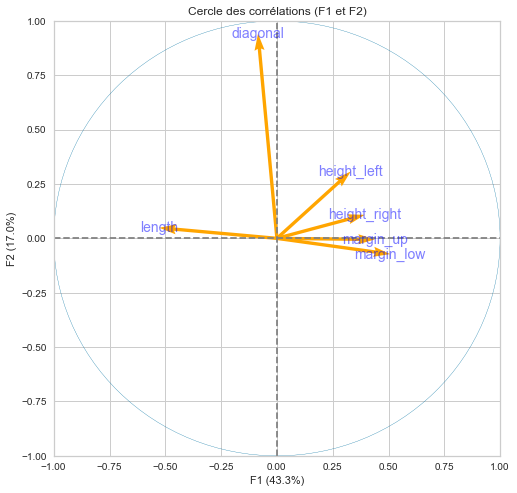

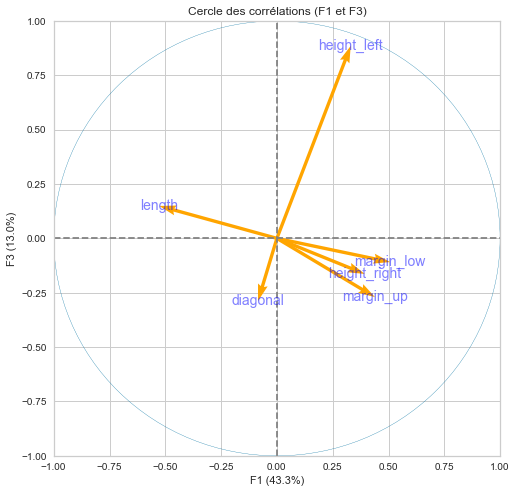

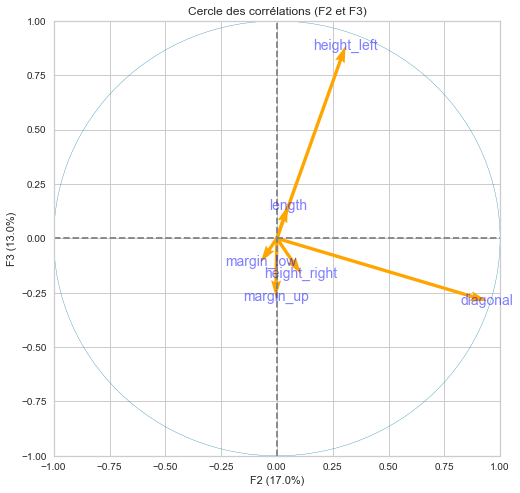

In [40]:
pcs = pca.components_
display_circles(pcs,n_comp , pca, [(0,1),(0,2),(1,2)], labels = np.array(nom_variable))



Les variables:margin_low est corrélée positivement à F1 tandis que length est corrélée négativement à F1.</br>
La variable: diagonale est fortement corrélée à F2.</br>
La variable heigh_left est fortement corrélée à F3.

### Projection des individus sur les 3 plans factoriels

In [41]:
X_projected = pca.transform(X_scaled)


In [42]:
def display_factorial_planes(X_projected, n_comp, pca, axis_ranks, labels=None, alpha=1, illustrative_var=None):
    for d1,d2 in axis_ranks:
        if d2 < n_comp:
 
            # initialisation de la figure      
            fig = plt.figure(figsize=(10,10))
       
            # affichage des points
            illustrative_var = np.array(billet.index.values)
            if illustrative_var is None:
                plt.scatter(X_projected[:, d1], X_projected[:, d2], alpha=alpha)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    plt.scatter(X_projected[selected, d1], X_projected[selected, d2], alpha=alpha, label=value)
                plt.legend()

            # affichage des labels des points
            if labels is not None:
                for i,(x,y) in enumerate(X_projected[:,[d1,d2]]):
                    plt.text(x, y, labels[i],
                            fontsize='14', ha='center',va='center')
               
            # détermination des limites du graphique
            boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
            plt.xlim([-boundary,boundary])
            plt.ylim([-boundary,boundary])
       
            # affichage des lignes horizontales et verticales
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Projection des individus (sur F{} et F{})".format(d1+1, d2+1),fontsize=20)
            plt.savefig(("Projection des individus (sur F{} et F{})".format(d1+1, d2+1)),dpi=300)
            plt.show(block=False)



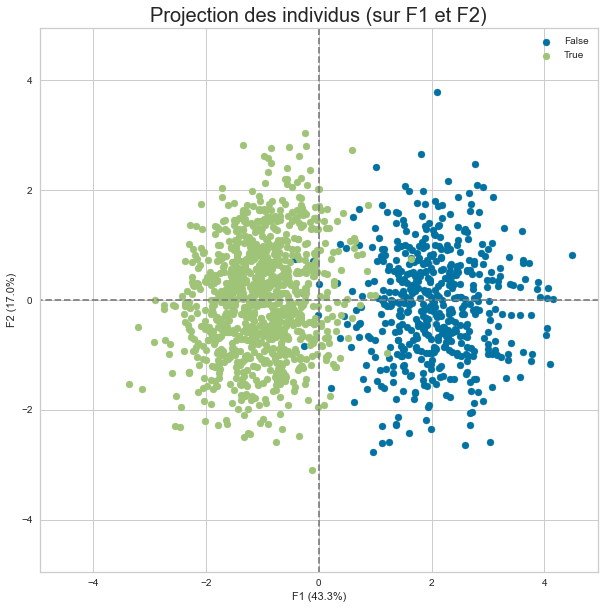

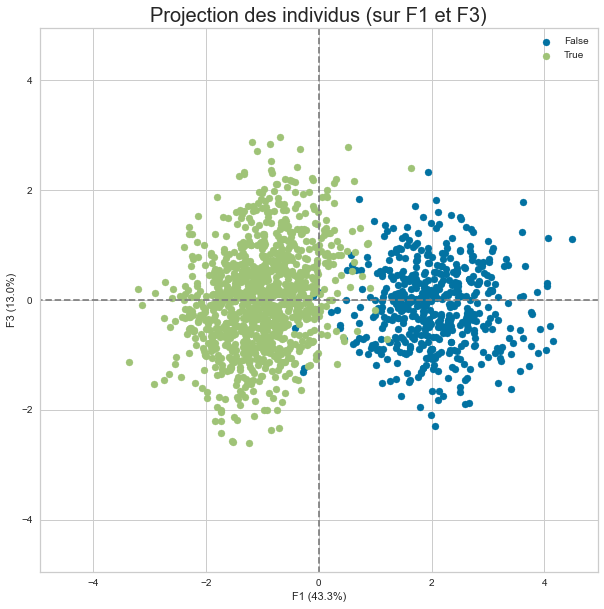

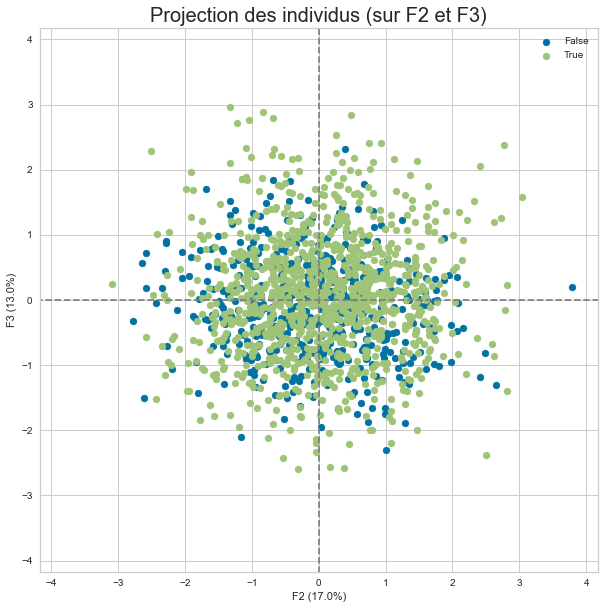

In [43]:
# Projection des individus
X_projected = pca.transform(X_scaled)
display_factorial_planes(X_projected, n_comp, pca, [(0,1),(0,2),(1,2)],illustrative_var=np.array(names))
plt.show(block=False)


Dans les 2 premiers plans factoriels, on voit bien 2 classes distincts, les classes des vrais et faux billets.</br>
On remarque aussi dans ces deux premiers plans factoriels que les vrais billets se trouvent à gauche de l'axe des ordonnées et les faux billets à sa droite. Si on se réfère aux cercles de corrélation, en valeur absolue, on peut dire que globalement ce qui différencie les vrais du faux billets c'est la longueur des variables margin_low et length.



# Modélisations des données <a class="anchor" id="chapter2">

## <font color='purple'>Régression logistique <a class="anchor" id="section_2_1"></a>


In [44]:
billet.reset_index(inplace=True)


In [45]:
billet.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54


In [46]:
X = billet.iloc[:,1:7].values
y = billet["is_genuine"]



In [47]:
#vérification
print(X.shape)
print(y.shape)

(1500, 6)
(1500,)


In [48]:
#partition apprentissage- test de données
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,  test_size=0.2,random_state= 100)   

print( X_train.shape, y_train.shape)
print( X_test.shape, y_test.shape)

(1200, 6) (1200,)
(300, 6) (300,)


In [49]:
# instanciation et apprentissage
modele= LogisticRegression()
modele.fit(X_train, y_train)

LogisticRegression()

In [50]:
#affichage des coefficients
print(modele.coef_)

[[-0.15662951 -1.70583506 -1.94424513 -3.59202804 -3.13141765  3.852435  ]]


In [51]:
#prédiction avec .predict()
y_pred= modele.predict(X_test)

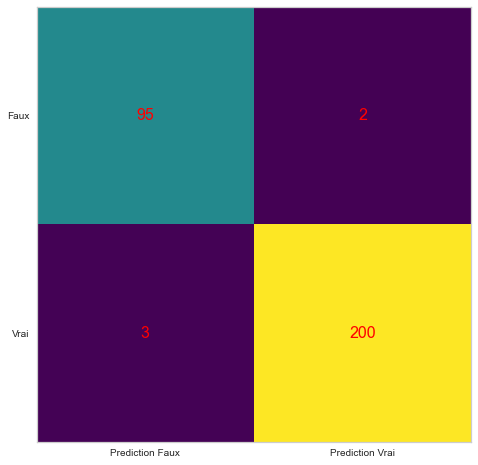

In [52]:
#Création d'un graphique pour la matrice de confusion
cm = confusion_matrix(y_test, modele.predict(X_test))

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm,cmap='viridis')
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Prediction Faux', 'Prediction Vrai'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Faux', 'Vrai'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], fontsize=16,ha='center',va='center', color='red')


plt.show()


### Rapport de classification

In [53]:
print(metrics.classification_report(y_test,y_pred)) 

              precision    recall  f1-score   support

       False       0.97      0.98      0.97        97
        True       0.99      0.99      0.99       203

    accuracy                           0.98       300
   macro avg       0.98      0.98      0.98       300
weighted avg       0.98      0.98      0.98       300



**Accuracy=justesse**: La fraction de vrais positifs et vrais négatifs. C'est le taux de bonne classification.</br>
**Précision**:  La capacité du modèle à ne pas labeliser positif un individus qui est négatif.</br>
**Rappel**: La capacité du modèle à trouver tous les individus positifs.</br>


### Autre mesure de performance: courbe ROC

In [54]:
y_pred_proba = modele.predict_proba(X_test)[:,1]


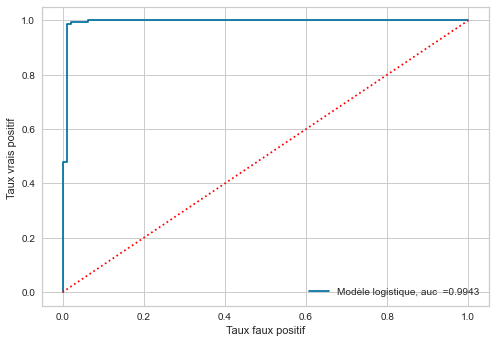

In [55]:
# Courbe ROC
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc =round( metrics.roc_auc_score(y_test, y_pred_proba),4)
plt.plot(fpr,tpr,label="Modèle logistique, auc  ="+str(auc))
plt.plot([0, 1], [0, 1],color="red", linestyle=":")
plt.legend(loc=4)
plt.xlabel('Taux faux positif')
plt.ylabel('Taux vrais positif ')
plt.show()


L'AUC est proche de 1, notre modèle est parfait.

## <font color='purple'>K-Means <a class="anchor" id="section_2_2"></a>


On sait déjà qu'on veut avoir deux clusters: vrais et faux billets.

In [56]:
billet_k=billet.set_index("is_genuine")

In [57]:
billet_k.index

Index([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
       ...
       False, False, False, False, False, False, False, False, False, False],
      dtype='object', name='is_genuine', length=1500)

In [58]:
std_scale = preprocessing.StandardScaler().fit(X_test)
X_scaled = std_scale.transform(X_test)

In [59]:
X_projected = pca.transform(X_scaled)


In [60]:
kmeans= KMeans(n_clusters= 2,random_state=1994)
kmeans.fit(X_scaled)


C:\Users\PC\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


KMeans(n_clusters=2, random_state=1994)

In [61]:
clusters=kmeans.labels_
clusters


array([0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0,
       0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1,
       0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1,
       1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0,
       1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1,
       0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1,
       0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0])

In [62]:
#calcul des centroïdes
centroids = kmeans.cluster_centers_                             
centroids

array([[-0.17787368,  0.44212156,  0.72311897,  1.14278231,  0.95511383,
        -1.20120272],
       [ 0.08370526, -0.20805721, -0.34029128, -0.53777991, -0.44946533,
         0.56527187]])

In [63]:
pd.DataFrame(centroids, columns=billet_k.columns)

,diagonal,height_left,height_right,margin_low,margin_up,length
0,-0.177874,0.442122,0.723119,1.142782,0.955114,-1.201203
1,0.083705,-0.208057,-0.340291,-0.537780,-0.449465,0.565272


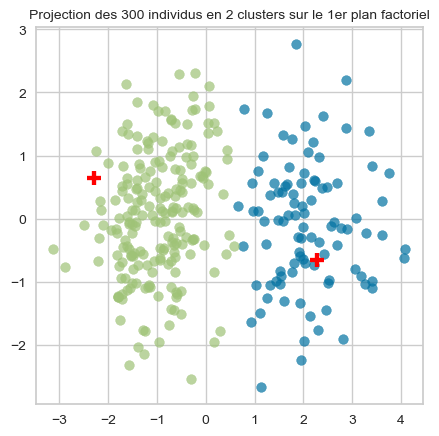

In [64]:
# Projection des individus (y compris les centroides de partitions) sur le 1er plan factoriel 

plt.figure(figsize=(5,5), dpi=100)
colormap = np.array([ 'g', 'b'])

# Centrage et Réduction
std_scaleC = preprocessing.StandardScaler().fit(centroids)     # centrage
C_scaled = std_scaleC.transform(centroids)   

centroids_projected = pca.transform(C_scaled)  

for k in [0,1]:    
    plt.scatter(X_projected[clusters==k, 0], X_projected[clusters==k, 1], cmap=colormap[clusters],alpha=0.7,label="Cluster{}".format(k))  
    plt.scatter(centroids_projected[:,0], centroids_projected[:,1], color='red', s=100, marker="+", lw=3, alpha=1)

plt.title("Projection des {} individus en 2 clusters sur le 1er plan factoriel".format(X_projected.shape[0]), fontsize=10)
plt.show()

Les deux clusters se distinguent clairement.

In [65]:
# Matrice de confusion
km_matrix = confusion_matrix(y_test, clusters)


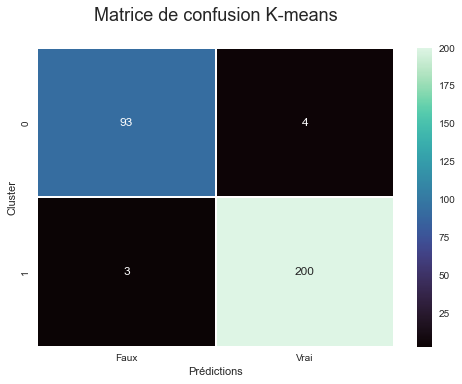

In [66]:
# Graphique:
sns.heatmap(km_matrix,
            annot = True,
            fmt = ".3g", 
            cmap = sns.color_palette("mako", as_cmap=True),
            linecolor = "white",
            linewidths = 0.3,
            xticklabels = ["Faux","Vrai"],
            yticklabels=["0","1"]
            )
plt.xlabel("Prédictions")
plt.ylabel("Cluster")
plt.title("Matrice de confusion K-means\n", fontsize=18)
plt.show()

Pour les variables **margin** et **height**, dont les centroïdes sont positifs pour les faux billets, tandis que pour **length** sont négatif pour les faux billets.

In [71]:
print(metrics.classification_report(y_test,clusters)) 

              precision    recall  f1-score   support

       False       0.97      0.96      0.96        97
        True       0.98      0.99      0.98       203

    accuracy                           0.98       300
   macro avg       0.97      0.97      0.97       300
weighted avg       0.98      0.98      0.98       300



## <font color='purple'> Algorithme de prédiction  <a class="anchor" id="section_2_3"></a>


In [67]:
# fonction pour la détection des faux billets
def detection_billet(dataset):
    
#vérification des variables
    liste_X = ["diagonal","height_left","height_right","margin_low","margin_up","length","id"]
    if all([item in dataset.columns for item in liste_X]):
        print("Les variables du fichier sont correctes. Voici un aperçu des données :\n\n",dataset)
    else :
        print("Erreur d'importation du fichier. Attention, les colonnes du fichier ne correspondent pas à la trame attendue !")
    
    if((dataset.isnull().sum(axis = 0)).sum() > 0):
        print("Valeurs nulles détectées.Attention, des valeurs nulles ont été détectées dans le fichier ! Traitement impossible en l'état.")
    
    else :
        print("Aucune valeur nulle détectée, le traitement peut continuer.")
    #creation des variables 
        X= dataset[liste_X[:-1]]

#calcul des probabilités d'affectation sur l'échantillon exemple
        probas= modele.predict_proba(X.values)

#score de presence : Probalilité de chance que le billet soit VRAI (is_genuine = True)
        score = probas[:,1]

#Ajout de la colonne probabilité
        dataset["proba_true"] = score
#calcul de la variable is_genuine
        dataset["is_genuine"] = np.where(dataset["proba_true"]<=0.5, 'False', 'True')
#traitement du Dataframe pour meilleure compréhension :                
        dataset_fin = dataset[["id","proba_true","is_genuine"]].rename(columns={"id":"Identifiant du billet testé",
                                                                                 "proba_true":"Probabilité que le billet soit VRAI (%)",
                                                                                 "is_genuine":"Authenticité"})
        dataset_fin["Probabilité que le billet soit VRAI (%)"] = round((dataset_fin["Probabilité que le billet soit VRAI (%)"]*100),2)
        return(dataset_fin)

### Test de l'algorithme

In [68]:
data= pd.read_csv('billets_production.csv',sep=',')
data


,diagonal,height_left,height_right,margin_low,margin_up,length,id
0,171.76,104.01,103.54,5.21,3.30,111.42,A_1
1,171.87,104.17,104.13,6.00,3.31,112.09,A_2
2,172.00,104.58,104.29,4.99,3.39,111.57,A_3
3,172.49,104.55,104.34,4.44,3.03,113.20,A_4
4,171.65,103.63,103.56,3.77,3.16,113.33,A_5


In [69]:

data.head()


,diagonal,height_left,height_right,margin_low,margin_up,length,id
0,171.76,104.01,103.54,5.21,3.30,111.42,A_1
1,171.87,104.17,104.13,6.00,3.31,112.09,A_2
2,172.00,104.58,104.29,4.99,3.39,111.57,A_3
3,172.49,104.55,104.34,4.44,3.03,113.20,A_4
4,171.65,103.63,103.56,3.77,3.16,113.33,A_5


In [70]:
detection_billet(data)

Les variables du fichier sont correctes. Voici un aperçu des données :

    diagonal  height_left  height_right  margin_low  margin_up  length   id
0    171.76       104.01        103.54        5.21       3.30  111.42  A_1
1    171.87       104.17        104.13        6.00       3.31  112.09  A_2
2    172.00       104.58        104.29        4.99       3.39  111.57  A_3
3    172.49       104.55        104.34        4.44       3.03  113.20  A_4
4    171.65       103.63        103.56        3.77       3.16  113.33  A_5
Aucune valeur nulle détectée, le traitement peut continuer.


,Identifiant du billet testé,Probabilité que le billet soit VRAI (%),Authenticité
0,A_1,0.41,False
1,A_2,0.07,False
2,A_3,0.10,False
3,A_4,91.57,True
4,A_5,99.97,True


In [75]:
test=pd.read_csv('test_P10.csv', sep=',')

In [76]:
test

,diagonal,height_left,height_right,margin_low,margin_up,length,id
0,172.09,103.95,103.73,4.39,3.09,113.19,B_1
1,171.52,104.17,104.03,5.27,3.16,111.82,B_2
2,171.78,103.80,103.75,3.81,3.24,113.39,B_3
3,172.02,104.08,103.99,5.57,3.30,111.10,B_4
4,171.79,104.34,104.37,5.00,3.07,111.87,B_5


In [77]:
detection_billet(test)

Les variables du fichier sont correctes. Voici un aperçu des données :

    diagonal  height_left  height_right  margin_low  margin_up  length   id
0    172.09       103.95        103.73        4.39       3.09  113.19  B_1
1    171.52       104.17        104.03        5.27       3.16  111.82  B_2
2    171.78       103.80        103.75        3.81       3.24  113.39  B_3
3    172.02       104.08        103.99        5.57       3.30  111.10  B_4
4    171.79       104.34        104.37        5.00       3.07  111.87  B_5
Aucune valeur nulle détectée, le traitement peut continuer.


,Identifiant du billet testé,Probabilité que le billet soit VRAI (%),Authenticité
0,B_1,99.02,True
1,B_2,0.73,False
2,B_3,99.93,True
3,B_4,0.01,False
4,B_5,1.14,False
